In [119]:
import json
import os
import pandas as pd

import math


In [120]:
#open file

fileList = os.listdir("data")

#fileList
f = open("data/"+"ESZ06.json")

data = json.load(f)

In [121]:
#Can't read pandas directly, unstrucutred messed of a file
#pdData = pd.read_json("data/"+fileList[0])

In [122]:
type(data.keys())

a = set([1,2,3])

In [123]:
sample = data["data"]
dfKeys = set(sample[0].keys()).difference({"raw"})
#Maybe don't set-ify an ordered collenction
df = pd.DataFrame(sample, columns=list(dfKeys))

In [124]:
df

,tradeTime,lowPrice,volume,percentChange,openPrice,openInterest,lastPrice,priceChange,highPrice
0,12/15/2006,"1,425.25",0,+0.19%,"1,426.00",0,"1,428.74",+2.74,"1,432.75"
1,12/14/2006,"1,412.00","216,489",+0.83%,"1,414.00","944,337","1,426.00",+11.75,"1,427.50"
2,12/13/2006,"1,410.75","219,370",+0.11%,"1,413.00","974,110","1,414.25",+1.50,"1,418.50"
3,12/12/2006,"1,405.00","333,953",-0.12%,"1,414.75","1,142,457","1,412.75",-1.75,"1,414.75"
4,12/11/2006,"1,409.50","294,738",+0.32%,"1,409.75","1,222,469","1,414.50",+4.50,"1,417.00"
...,...,...,...,...,...,...,...,...,...
59,09/22/2006,"1,321.00","892,984",-0.32%,"1,330.00","1,346,924","1,326.00",-4.25,"1,331.50"
60,09/21/2006,"1,325.50","1,248,340",-0.47%,"1,336.50","1,352,953","1,330.25",-6.25,"1,340.00"
61,09/20/2006,"1,329.50","970,246",+0.45%,"1,330.75","1,324,711","1,336.50",+6.00,"1,339.75"
62,09/19/2006,"1,322.75","1,176,450",-0.28%,"1,333.75","1,303,729","1,330.50",-3.75,"1,334.50"


In [125]:
#Lazy conversion on my end, could've used locales
#str -> specify non total item replacement
df["lastPrice"] = df["lastPrice"].str.replace(",","").astype("float64")
df["tradeTime"] = df["tradeTime"].apply(pd.to_datetime)

In [126]:
df.dtypes

tradeTime        datetime64[ns]
lowPrice                 object
volume                   object
percentChange            object
openPrice                object
openInterest             object
lastPrice               float64
priceChange              object
highPrice                object
dtype: object

In [127]:
import seaborn

In [128]:
#sample = [(x["tradeTime"],x["lastPrice"]) for x in data["data"]]

Text(0, 0.5, 'Last Price')

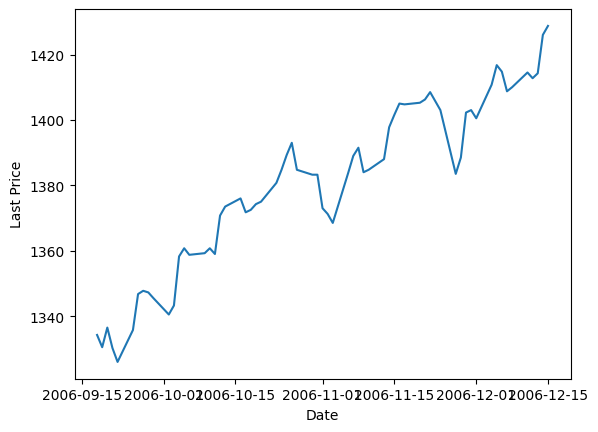

In [129]:
ss = seaborn.lineplot(x="tradeTime", y="lastPrice", data=df)
ss.set_xlabel("Date")
ss.set_ylabel("Last Price")

In [130]:
max(df["tradeTime"])-min(df["tradeTime"])

Timedelta('88 days 00:00:00')

In [131]:
logRets = (df["lastPrice"].shift(1)/df["lastPrice"]).apply(math.log) #Indexes kept

In [132]:
#Add to 
df["logReturns"] = logRets
#Indexes are kept throughout series!
df = df.drop(0) #drop the first entry for simplicity

<Axes: xlabel='tradeTime', ylabel='logReturns'>

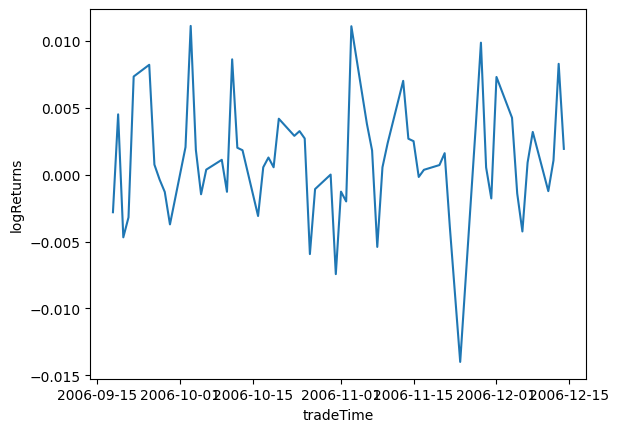

In [133]:
seaborn.lineplot(x="tradeTime", y="logReturns", data=df)

(array([ 1.,  0.,  1.,  4.,  8., 19., 16.,  5.,  5.,  4.]),
 array([-0.01399628, -0.01148615, -0.00897601, -0.00646588, -0.00395575,
        -0.00144561,  0.00106452,  0.00357465,  0.00608479,  0.00859492,
         0.01110506]),
 <BarContainer object of 10 artists>)

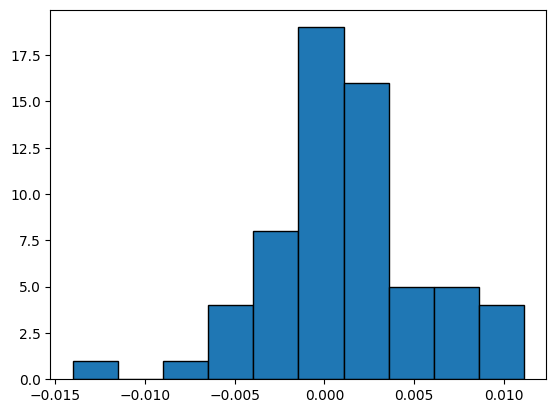

In [134]:
import matplotlib.pyplot as plt
plt.hist(df["logReturns"], edgecolor='black')

In [135]:
import statsmodels.api as sm

In [136]:
#Setup dist
import scipy.stats

#Assuming daily returns, ignoring weekends and bank holidays
bmStdDev = df["logReturns"].std()
bMotion = scipy.stats.norm(loc=0, scale=bmStdDev)

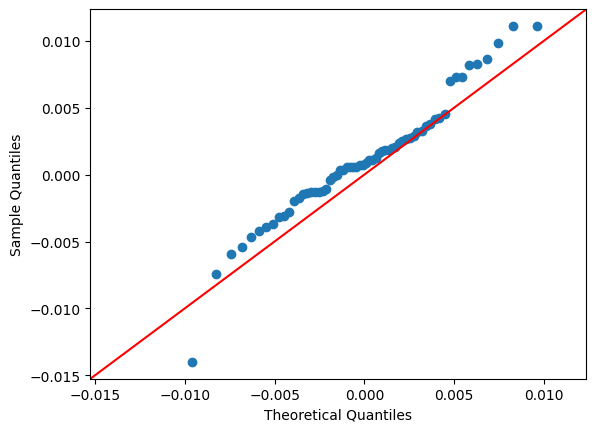

In [137]:
fig = sm.qqplot(df["logReturns"][1:], dist=bMotion, line='45')

In [66]:
#Null Hyp: The underlying dist is normal
scipy.stats.shapiro(df["logReturns"])

ShapiroResult(statistic=0.9807717198484012, pvalue=0.42849579415746947)

In [22]:
df["logReturns"][1:]

2     0.044678
3     0.023936
4    -0.015479
5    -0.011499
6    -0.003388
        ...   
59    0.014974
60    0.002575
61    0.013497
62   -0.006598
63    0.004684
Name: logReturns, Length: 62, dtype: float64

In [81]:
def logRet_shapiroTest(str):
    with open("data/"+str) as f:
        data = json.load(f)

    sample = data["data"]
    dfKeys = set(sample[0].keys()).difference({"raw"})
    #Maybe don't set-ify an ordered collenction
    df = pd.DataFrame(sample, columns=list(dfKeys))

    df["lastPrice"] = df["lastPrice"].str.replace(",","").astype("float64")
    df["tradeTime"] = df["tradeTime"].apply(pd.to_datetime)

    logRets = (df["lastPrice"].shift(1)/df["lastPrice"]).apply(math.log) #Indexes kept
    df["logReturns"] = logRets
    #Indexes are kept throughout series!
    df = df.drop(0) #drop the first entry for simplicity

    bmStdDev = df["logReturns"].std()
    bMotion = scipy.stats.norm(loc=0, scale=bmStdDev)

    #Null Hyp: The underlying dist is normal
    return scipy.stats.shapiro(df["logReturns"]).pvalue


In [83]:
logRet_shapiroTest(fileList[0])

0.42849579415746947

In [74]:
fileList[0]

'ESH00.json'

In [89]:
testResults = [(x, logRet_shapiroTest(x)) for x in os.listdir("data")]

In [109]:
import re

In [110]:
testResults.sort(key = lambda xs: re.sub("^([a-zA-Z]+)([0-9]+)", "\\2\\1", xs[0])) #Python's RE's are annoyingly close to vims

In [113]:
testResults

[('ESH00.json', 0.42849579415746947),
 ('ESM00.json', 0.0063358213883641665),
 ('ESU00.json', 0.5259736240549313),
 ('ESZ00.json', 0.010471633567879782),
 ('ESH01.json', 0.15290983530385394),
 ('ESM01.json', 0.7729622826916323),
 ('ESU01.json', 0.0042875978082339),
 ('ESZ01.json', 0.16358181158370394),
 ('ESH02.json', 0.2132069608861651),
 ('ESM02.json', 0.25344551346195565),
 ('ESU02.json', 0.281098265148784),
 ('ESZ02.json', 0.29407277927188313),
 ('ESH03.json', 0.2889709753969352),
 ('ESM03.json', 0.3572402298741022),
 ('ESU03.json', 0.9121604968072285),
 ('ESZ03.json', 0.47461146529060866),
 ('ESH04.json', 0.23235897336807054),
 ('ESM04.json', 0.2479168981984718),
 ('ESU04.json', 0.10506854270887084),
 ('ESZ04.json', 0.12389720800212178),
 ('ESH05.json', 0.3436704719134535),
 ('ESM05.json', 0.2011481802492373),
 ('ESU05.json', 0.815080012906108),
 ('ESZ05.json', 0.5133250267943034),
 ('ESH06.json', 0.37685862425664773),
 ('ESM06.json', 0.7062640925232222),
 ('ESU06.json', 0.3709145

In [118]:
infractors = [x for (x,p) in testResults if p < 0.1]
infractors

['ESM00.json',
 'ESZ00.json',
 'ESU01.json',
 'ESZ06.json',
 'ESH07.json',
 'ESM07.json',
 'ESH08.json',
 'ESM08.json',
 'ESU09.json',
 'ESH10.json',
 'ESM10.json',
 'ESZ10.json',
 'ESH11.json',
 'ESU11.json',
 'ESH12.json',
 'ESU12.json',
 'ESH13.json',
 'ESM13.json',
 'ESU13.json',
 'ESH14.json',
 'ESM14.json',
 'ESU14.json',
 'ESU15.json',
 'ESU16.json',
 'ESZ16.json',
 'ESM17.json',
 'ESU17.json',
 'ESH18.json',
 'ESM18.json',
 'ESH19.json',
 'ESM19.json',
 'ESU19.json',
 'ESZ19.json',
 'ESH20.json',
 'ESM20.json',
 'ESU20.json',
 'ESZ20.json',
 'ESU22.json',
 'ESH98.json',
 'ESU98.json',
 'ESZ98.json']